In [1]:
%matplotlib inline 
import numpy as np
import os
import astropy.time
import astropy.units as u
from astropy import constants as const
import dateutil.parser
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import astropy.io.ascii
from matplotlib.patches import Ellipse
from matplotlib.animation import FuncAnimation
from scipy.interpolate import interp1d
from at2019dsg.plotting import big_fontsize, fontsize, fig_width, plot_dir
from at2019dsg.data import data_dir

In [2]:
xsec_pp = 4e-26 # proton-prorton x-section in cm^-2
xsec_pg = 4e-28 # proton-gamma at delta resonance
xsec_xe = 6.7e-25 # x-rays - electrons 
k_b = 1.381e-23 # J/K
sigma_b = 5.67e-12 # W/cm2/K4

discovery_d = dateutil.parser.parse('2019.04.09')
time = astropy.time.Time(discovery_d)

In [3]:
dates = []
flux_max=np.array([0.4, 0.7, 2., 2.])
freq_max=np.array([10,10,10,6])

dt = dateutil.parser.parse('2019.04.09')
time_discovery = astropy.time.Time(dt)


#r_eq = [1.62e16, 2.5e16,4.06e16, 6.62e16]
r_eq = np.array([pow(10,16.18), pow(10,16.37), pow(10,16.57), pow(10,16.82)])


obs_dates = ['2019.05.22','2019.06.19','2019.08.08','2019.10.05']

for obs in obs_dates:

    time = [] 
    dt = dateutil.parser.parse(obs)
    time = astropy.time.Time(dt)
    dates.append(time.jd-time_discovery.jd)


nu_day=174

dates = np.array(dates)

# next comes the BB radius 

data = astropy.io.ascii.read(os.path.join(data_dir, 'BranStark_RT.dat.txt'))
rad_bb = pow(10,data['R_cm'])
t_bb = pow(10,data['T_K'])


e_g = 2.7 * k_b * t_bb 

# next comes the nu-proton interaction radius 
optical_lumi = sigma_b * 3.14 * pow(rad_bb,2)*pow(t_bb,4)
r_pg= optical_lumi/e_g/4/3.14/3e10*xsec_pg

x = [-100.0] + list(data["MJD"] - time_discovery.mjd) + [1001.]

y = [rad_bb[0]] + list(rad_bb) + [rad_bb[-1]]

f = interp1d(x, y)

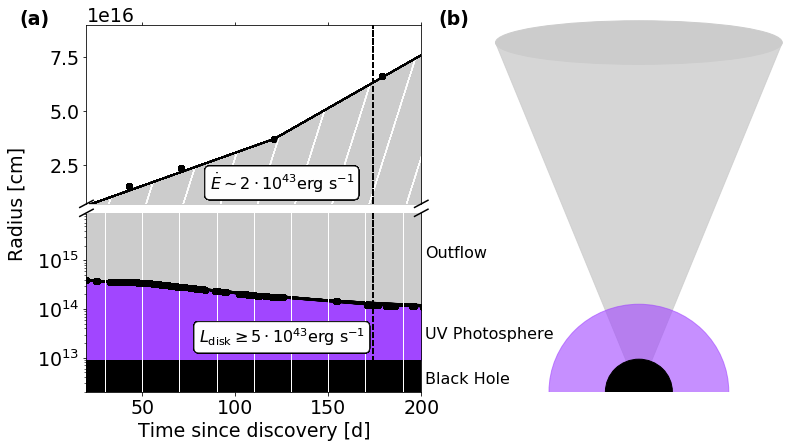

In [4]:
frames=100

scale1=300/frames

scale2 = 10/frames

fig = plt.figure(figsize=(fig_width * 2., fig_width * 18./16.))

ax1a = fig.add_subplot(2, 2, 1)
ax1a.annotate("(a)", (-0.2, 1.0), xycoords="axes fraction", fontsize=big_fontsize, fontweight='bold')
ax2 = plt.subplot(122)
ax1a.annotate("(b)", (1.05, 1.0), xycoords="axes fraction", fontsize=big_fontsize, fontweight='bold')
plt.setp(ax1a.get_xticklabels(), visible=False)

ax1a_lims = [7e15,0.9e17]

ax1a.set_ylim(ax1a_lims)

ax1b = fig.add_subplot(2, 2, 3, sharex=ax1a)
ax1b.set_yscale('log')

ax1a.set_ylabel('Radius [cm]', size=big_fontsize)
ax1b.set_xlabel('Time since discovery [d]', size=big_fontsize)

x = np.linspace(30., 190., 30)

ax1b_lims = [2e12, 9.5e15]
ax1b.set_ylim(ax1b_lims)

# the photospheres

r_bb=1e14
r_pg=r_bb
days=np.arange(0,200,1)


# the jets

lw=1
offset=0.5


# radio boundary
d1 = 0
r1 = 0
d2 = dates[2]
r2 = r_eq[2]
d3 = 200
r3 = r_eq[3]*1.15

grad_1 = (r2-r1)/(d2-d1)
c_1 = r2 - grad_1 * d2

def radio_rad_1(t):
    return grad_1 * t + c_1

grad_2 = (r3-r2)/(d3-d2)
c_2 = r3 - grad_2 * d3

def radio_rad_2(t):
    return grad_2 * t + c_2


grey_colour = "0.8"

# labels

d = .02  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1a.transAxes, color='k', clip_on=False)
ax1a.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1a.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax1b.transAxes)  # switch to the bottom axes
ax1a.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax1b.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

r_s = (2. * const.G * const.M_sun * (3 * 10**7)/const.c**2).to("cm").value

# merge the two graphs
ax1a.spines['bottom'].set_visible(False)
ax1b.spines['top'].set_visible(False)
ax1a.xaxis.tick_top()
ax1a.tick_params(labeltop=False)  # don't put tick labels at the top
ax1b.xaxis.tick_bottom()

ax1a.yaxis.set_label_coords(-0.18, 0)
plt.subplots_adjust(wspace=0, hspace=0.05)
ax1a.tick_params(axis='both', which='both', labelsize=big_fontsize)
ax1a.yaxis.get_offset_text().set_fontsize(big_fontsize)
ax1b.tick_params(axis='both', which='both', labelsize=big_fontsize)
ax2.tick_params(axis='both', which='both', labelsize=big_fontsize)
plt.xlim([20, 200])

x_center_diagram = 1.2

def make_artists(y):

    tri = [[x_center_diagram,0], [x_center_diagram-y/2.5,y], [x_center_diagram+y/2.5, y]]
        
    ell = ((x_center_diagram, y), 0.8*y, y/8)
    
    return tri, ell

def r_plot_uv(r_uv):
    return 4.5 * ((np.log(r_uv) - np.log(ax1b_lims[0]))/(np.log(ax1b_lims[1]) - np.log(ax1b_lims[0])))


ax2.set_xlim(-4, 4)
ax2.set_ylim(0, 9)
ax2.axison = False

uv = plt.Circle((x_center_diagram,0), r_plot_uv(f(20.)), color='#A146FF', alpha=0.6)
ax2.add_artist(uv)

bh = plt.Circle((x_center_diagram,0),0.8, color="black")
ax2.add_artist(bh)

tri, ell = make_artists(4.5)

t1 = plt.Polygon(tri, color=grey_colour, alpha=0.8)
ax2.add_patch(t1)

e1 = Ellipse(ell[0], width=ell[1], height=ell[2], color=grey_colour)
ax2.add_patch(e1)

label = False

def update_plot(j):
    
    ndays = j * scale1
    
    
    # Left plot
    
    if ndays > nu_day:
        
        # the neutrino
        ax1b.plot([nu_day, nu_day], [1, 2e17], 'k--', zorder=4)
        ax1a.plot([nu_day, nu_day], [1, 2e17], 'k--', zorder=4)
                            
    if ndays < d2:
                
        r_radio = radio_rad_1(ndays)
        
        ax1a.plot([d1, ndays], [r1, r_radio], 'k-', zorder=4)
        ax1a.fill_between([d1, ndays], [r1, r_radio], [1e15, 1e15], color=grey_colour,alpha=1)
        
    else:
        
        r_radio = radio_rad_2(ndays)
        
        ax1a.plot([d1, d2], [r1, r2], 'k-', zorder=4)
        ax1a.fill_between([d1, d2], [r1, r2], [1e15, 1e15], color=grey_colour,alpha=1)
        
        ax1a.plot([d2, ndays], [r2, r_radio], 'k-', zorder=4)
        ax1a.fill_between([d2, ndays], [r2, r_radio], [1e15, 1e15], color=grey_colour,alpha=1)
        
    mask = (data['MJD']- time_discovery.mjd) < ndays
    
    if np.sum(mask) > 0:
        ax1b.plot(data['MJD'][mask]- time_discovery.mjd, rad_bb[mask], 'o', color='black', zorder=4)
        
    
    mask = dates < ndays
    
    if np.sum(mask) > 0:

        ax1a.plot(dates[mask], r_eq[mask], 'o', color='black')
        
    if ndays > 20.:
        
        ax1b.fill_between([0., ndays], [1.e12, 1.e12], [1.e16, 1.e16], color=grey_colour)

        t_range = np.linspace(20., ndays, 5)
        ax1b.plot(t_range, f(t_range), color='k')
        ax1b.fill_between(t_range, f(t_range), r_s * np.ones_like(t_range), color='#A146FF')

        r_uv = f(ndays)

        ax1b.fill_between([0, ndays],[r_s, r_s],color='black')
        
        for x in range(0, 20):
            radius = 1e17
            c_light = 3.15e10 * 3600. *24. # speed of light in cm per day 
            step = 20    
            offs = 0
            if x>5:
                step =20
                offs = 0

            day_start = x * step + 10 + offs
            day_end = x * step + 10 + radius / c_light + offs

            ax1a.plot([day_start-offset, day_end-offset], [1, radius], 'k-',linewidth=lw, color='white')
            ax1b.plot([day_start, day_start], [1, radius], 'k-', linewidth=lw,color = 'white')


        # Right Plot


        if ndays < 200:

            [p.remove() for p in reversed(ax2.patches)]
            [p.remove() for p in reversed(ax2.artists)]

            r_outflow = 4.5* (1. + r_radio/(ax1a_lims[1] - ax1a_lims[0]))

            tri, ell = make_artists(r_outflow)

            t1 = plt.Polygon(tri, color=grey_colour, alpha=0.8, clip_on=False)
            ax2.add_patch(t1)

            e1 = Ellipse(ell[0], width=ell[1], height=ell[2], color=grey_colour, clip_on=False)
            ax2.add_patch(e1)

    #         r_plot_uv = 4.5* ((np.log(r_uv) - np.log(ax1b_lims[0]))/(np.log(ax1b_lims[1]) - np.log(ax1b_lims[0])))

            uv = plt.Circle((x_center_diagram, 0), r_plot_uv(r_uv), color='#A146FF', alpha=0.6)
            ax2.add_artist(uv)

            bh = plt.Circle((x_center_diagram, 0),0.8, color="black")
            ax2.add_artist(bh)
            
        else:
            alpha = 0.8
            
            props = dict(boxstyle='round', facecolor='white', alpha=alpha)
            
            x_for_text = 125.
            
            if j < (0.80 * frames):
                   
                [p.remove() for p in reversed(ax2.texts)]

                ax2.text(-3.9, 0.2, "Black Hole", fontsize=fontsize, ha='left')
                ax2.text(-3.9, 1.3, "UV Photosphere", fontsize=fontsize, ha='left')
                ax2.text(-3.9, 3.3, "Outflow", fontsize=fontsize, ha='left')

            else:
                ax1a.text(x_for_text, 1.35e16, r'$\dot{E} \sim 2 \cdot 10^{43} \rm erg~s^{-1}$', fontsize=fontsize, bbox=props, ha='center')
                ax1b.text(x_for_text, 2e13, r'$L_{\rm disk} \geq 5 \cdot 10^{43} \rm erg~s^{-1}$', fontsize=fontsize, bbox=props, ha='center')
            
ani = FuncAnimation(fig, update_plot, frames=frames, interval=30,
                    blit=False)
ani.save(os.path.join(plot_dir, "figure_3_animation.mp4"))
plt.savefig(os.path.join(plot_dir, "figure_3_diagram.pdf"))